In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [96]:
from scipy import stats

In [3]:
sys.path.append('../utils/')

In [4]:
from dlc_helper import DLC_tracking
from features import *
from features_speed import *
from preprocess_dlc import *

In [5]:
from joblib import Parallel, delayed

# DLC Data

In [6]:
with open(r'path_to_videos_with_dlc_results_to_calc_speed.txt', 'r') as file:
    list_DLC_filepaths = [line.rstrip() for line in file]
len(list_DLC_filepaths)

500

In [31]:
def get_features(filepath):

    # Read the DLC results file as a pandas DataFrame object
    filename = os.path.basename(filepath)
    foldername = os.path.dirname(filepath)
    dlc_obj = DLC_tracking(filename, foldername)
    df_data = dlc_obj.df_data

    # Interpolate missing datapoints (dorsal)
    df_dorsal = df_data.filter(regex='^(NT_|TT_|D).*(x|y)$')
    df_dorsal_filt = df_dorsal[df_dorsal.isna().sum(axis=1) < 5]
    df_dorsal_x = df_dorsal_filt.filter(like='_x')
    df_dorsal_y = df_dorsal_filt.filter(like='_y')
    df_dorsal_interp_x = interpol_spatial(df_dorsal_x)
    df_dorsal_interp_y = interpol_spatial(df_dorsal_y)
    df_dorsal_x_fin = interpol_temporal(df_dorsal_interp_x)
    df_dorsal_y_fin = interpol_temporal(df_dorsal_interp_y)
    df_dorsal_fin = df_dorsal_x_fin.join(df_dorsal_y_fin)[df_dorsal.columns]
    dorsal_xy_vals = df_dorsal_fin.values.reshape((-1,15,2))
    
    # Calculate length
    skel_lengths = get_length(dorsal_xy_vals)
    skel_lengths_ppsum = get_length(dorsal_xy_vals, len_type='sum_point_to_point')
    skel_lengths_ppavg = get_length(dorsal_xy_vals, len_type='mean_point_to_point')
    df_skel_lengths = pd.DataFrame(index= df_dorsal_fin.index, columns=['len_NT_to_TT', 'len_sum_of_parts', 'len_mean_of_parts'])
    df_skel_lengths['len_NT_to_TT'] = list(skel_lengths)
    df_skel_lengths['len_sum_of_parts'] = list(skel_lengths_ppsum)
    df_skel_lengths['len_mean_of_parts'] = list(skel_lengths_ppavg)

    # Calculate curvatures
    curv_vals = get_curv_savgol(dorsal_xy_vals, wl=9)
    df_curv = pd.DataFrame(curv_vals, index= df_dorsal_fin.index, columns=[f'curv_{x.split("_")[0]}' for x in df_dorsal_x.columns])

    # Calculate quirkiness
    quirkiness = get_quirkiness(dorsal_xy_vals)
    df_quirk = pd.DataFrame(quirkiness,  index= df_dorsal_fin.index, columns=['quirkiness'])

    # Calculate speeds
    # df_dorsal_speeds = get_speeds(df_dorsal_fin)
    df_dorsal_speeds = get_speeds(df_dorsal_fin.reindex(df_data.index), filt=True)
    df_dorsal_speeds = df_dorsal_speeds.reindex(df_dorsal_fin.index)
    
    # Interpolate missing datapoints (ventral) if less than 2 ventral points are missing!
    df_ventral = df_data.filter(regex='^V.*(x|y)$')
    df_ventral_filt = df_ventral[df_ventral.isna().sum(axis=1) < 5]
    df_ventral_x = df_ventral_filt.filter(like='_x')
    df_ventral_y = df_ventral_filt.filter(like='_y')
    df_ventral_interp_x = interpol_spatial(df_ventral_x)
    df_ventral_interp_y = interpol_spatial(df_ventral_y)
    df_ventral_x_fin = interpol_temporal(df_ventral_interp_x)
    df_ventral_y_fin = interpol_temporal(df_ventral_interp_y)
    df_ventral_fin = df_ventral_x_fin.join(df_ventral_y_fin)[df_ventral.columns]

    # Calculate speed : ventral
    df_ventral_speeds = get_speeds(df_ventral_fin.reindex(df_data.index), filt=True)
    df_ventral_speeds = df_ventral_speeds.reindex(df_ventral_fin.index)

    # Is mouth visible
    df_mouth = df_data[['MOUTH_x', 'MOUTH_y']].notna().mean(axis=1)
    df_mouth.name = 'MOUTH'
    
    # Combine all features
    df_feats = df_skel_lengths.join([df_curv, df_quirk, df_dorsal_speeds, df_ventral_speeds])
    df_feats_fin = df_feats.join(df_mouth, how='outer')
    # Test 
    print(df_data.index.min(), df_data.index.max(), len(df_data.index))
    print(df_dorsal_fin.index.min(), df_dorsal_fin.index.max(), len(df_dorsal_fin.index))
    print(df_skel_lengths.index.min(), df_skel_lengths.index.max(), len(df_skel_lengths.index))
    print(df_curv.index.min(), df_curv.index.max(), len(df_curv.index))
    print(df_quirk.index.min(), df_quirk.index.max(), len(df_quirk.index))
    print(df_dorsal_speeds.index.min(), df_dorsal_speeds.index.max(), len(df_dorsal_speeds.index))
    print(df_ventral_speeds.index.min(), df_ventral_speeds.index.max(), len(df_ventral_speeds.index))
    print(df_mouth.index.min(), df_mouth.index.max(), len(df_mouth.index))
    print(df_feats.index.min(), df_feats.index.max(), len(df_feats.index))

    return df_feats_fin
    

In [32]:
filename = os.path.basename(list_DLC_filepaths[0])
foldername = os.path.dirname(list_DLC_filepaths[0])
dlc_obj = DLC_tracking(filename, foldername)
df_data = dlc_obj.df_data
df_data

,frame,NT_x,NT_y,NT_likelihood,EYE_x,EYE_y,EYE_likelihood,DH1_x,DH1_y,DH1_likelihood,...,VNP_x,VNP_y,VNP_likelihood,MOUTH_x,MOUTH_y,MOUTH_likelihood,NTB_x,NTB_y,NTB_likelihood,n_missing_bodyparts
0,0,938.709,947.858,1.0,932.352,950.601,1.000,929.490,952.763,1.000,...,921.783,962.363,1.000,NaN,NaN,0.000,934.396,954.232,1.000,1
1,1,1044.959,884.471,1.0,1040.227,886.421,1.000,1035.960,887.879,1.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,13
2,2,1049.591,883.028,1.0,1041.855,884.872,0.997,1036.525,889.866,0.819,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,13
3,3,1045.842,883.475,1.0,1041.295,884.769,1.000,1035.775,886.278,1.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,13
4,4,1045.890,883.220,1.0,1041.345,884.592,1.000,1036.169,885.256,1.000,...,NaN,NaN,0.000,NaN,NaN,0.000,NaN,NaN,0.000,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26979,26979,492.915,933.890,1.0,485.851,929.593,1.000,483.594,926.838,1.000,...,476.487,917.913,0.999,478.956,924.577,0.373,484.922,929.262,0.996,0
26980,26980,494.674,934.454,1.0,490.396,931.008,1.000,484.374,928.463,1.000,...,476.052,921.923,1.000,484.874,924.627,0.840,491.193,930.407,1.000,0
26981,26981,495.626,935.882,1.0,490.513,932.308,1.000,485.800,928.844,1.000,...,476.427,922.254,1.000,485.451,924.679,0.758,491.524,930.549,1.000,0
26982,26982,496.118,935.861,1.0,491.233,933.039,1.000,486.615,929.731,1.000,...,476.531,922.400,1.000,485.646,924.512,0.660,492.209,931.309,1.000,0


In [33]:
# Testing 
df_feats_test = get_features(list_DLC_filepaths[0])

0 26983 26984
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 26635
0 26983 15328
0 26983 26984
0 26983 26635


In [34]:
df_feats_test.columns

Index(['len_NT_to_TT', 'len_sum_of_parts', 'len_mean_of_parts', 'curv_NT',
       'curv_DH1', 'curv_DH2', 'curv_DNP', 'curv_DTP1', 'curv_DTP2',
       'curv_DTP3', 'curv_DTP4', 'curv_DTP5', 'curv_DTP6', 'curv_DTP7',
       'curv_DTP8', 'curv_DTP9', 'curv_DTP10', 'curv_TT', 'quirkiness',
       'speed_NT', 'speed_DH1', 'speed_DH2', 'speed_DNP', 'speed_DTP1',
       'speed_DTP2', 'speed_DTP3', 'speed_DTP4', 'speed_DTP5', 'speed_DTP6',
       'speed_DTP7', 'speed_DTP8', 'speed_DTP9', 'speed_DTP10', 'speed_TT',
       'speed_VTP10', 'speed_VTP9', 'speed_VTP8', 'speed_VTP7', 'speed_VTP6',
       'speed_VTP5', 'speed_VTP4', 'speed_VTP3', 'speed_VTP2', 'speed_VTP1',
       'speed_VNP', 'MOUTH'],
      dtype='object')

In [35]:
df_feats_test

,len_NT_to_TT,len_sum_of_parts,len_mean_of_parts,curv_NT,curv_DH1,curv_DH2,curv_DNP,curv_DTP1,curv_DTP2,curv_DTP3,...,speed_VTP8,speed_VTP7,speed_VTP6,speed_VTP5,speed_VTP4,speed_VTP3,speed_VTP2,speed_VTP1,speed_VNP,MOUTH
0,58.556391,121.986974,8.132465,0.002747,0.008599,0.005984,0.004895,0.002223,0.006569,-0.008459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,54.780271,112.061200,7.470747,-0.006481,-0.003456,-0.006633,-0.015413,-0.023643,-0.007650,-0.006967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,60.175949,128.351231,8.556749,-0.003500,-0.003287,-0.003524,-0.006942,-0.010419,-0.042153,-0.027122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,53.550173,111.557206,7.437147,-0.010190,-0.009334,-0.010965,-0.018913,-0.025498,-0.025259,-0.017712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,53.429537,111.996814,7.466454,-0.011177,-0.007488,-0.009124,-0.016018,-0.022658,-0.022512,-0.024905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26979,62.535811,131.711095,8.780740,-0.004498,0.013581,0.010846,0.015934,0.007099,0.006494,-0.018113,...,1.487509,0.519466,0.890056,1.043500,0.954671,1.282710,1.980657,1.099788,0.649841,1.0
26980,63.796707,138.178865,9.211924,0.003837,0.017206,0.012029,0.022416,0.012456,0.012042,-0.023597,...,3.650316,1.208696,1.081178,1.848774,4.119352,2.940045,1.927615,1.374147,4.033525,1.0
26981,63.740053,130.713959,8.714264,-0.000404,0.012740,0.008586,0.004964,0.005638,0.005200,-0.009309,...,1.388051,1.115314,1.168666,1.077937,1.799903,1.143079,1.186459,0.792275,0.500186,1.0
26982,63.726518,130.585867,8.705724,-0.000523,0.013757,0.011148,0.008187,0.007357,0.006588,-0.007304,...,1.144502,1.104141,0.589482,0.665776,1.610587,0.345701,0.825252,0.631373,0.179254,1.0


In [180]:
list_df_feats = Parallel(n_jobs=6)(delayed(get_features)(fpath, ) for fpath in list_DLC_filepaths[:50])

# Outliers and other stats

In [264]:
def remove_outliers(df, col, thresh=[0,120]):
    # global outlier_free_list 
    global df_wo_outliers

    if col.startswith('curv'):
        Q1, Q3 = df[col].quantile([.25, .75])
        IQR = Q3 - Q1
        
        thresh[0] = Q1 - 5 * IQR
        thresh[1] = Q3 + 5 * IQR
        df_wo_outliers = df[(df[col] > thresh[0]) & (df[col] < thresh[1])]
        
    elif col.startswith('len'):
        df_wo_outliers = df[(df[col] > thresh[0]) & (df[col] < thresh[1])]

    elif col.startswith('speed'):
        df_wo_outliers = df[(df[col] > thresh[0]) & (df[col] < thresh[1])]
        

In [265]:
df_combined_test = pd.concat(list_df_feats)
df_combined_test

,len_NT_to_TT,len_sum_of_parts,len_mean_of_parts,curv_NT,curv_DH1,curv_DH2,curv_DNP,curv_DTP1,curv_DTP2,curv_DTP3,...,speed_VTP8,speed_VTP7,speed_VTP6,speed_VTP5,speed_VTP4,speed_VTP3,speed_VTP2,speed_VTP1,speed_VNP,MOUTH
0,58.556391,121.986974,8.132465,0.002747,0.008599,0.005984,0.004895,0.002223,0.006569,-0.008459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,54.780271,112.061200,7.470747,-0.006481,-0.003456,-0.006633,-0.015413,-0.023643,-0.007650,-0.006967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,60.175949,128.351231,8.556749,-0.003500,-0.003287,-0.003524,-0.006942,-0.010419,-0.042153,-0.027122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,53.550173,111.557206,7.437147,-0.010190,-0.009334,-0.010965,-0.018913,-0.025498,-0.025259,-0.017712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,53.429537,111.996814,7.466454,-0.011177,-0.007488,-0.009124,-0.016018,-0.022658,-0.022512,-0.024905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8996,62.839559,1609.469719,107.297981,0.014835,0.011311,0.011667,0.019573,0.028113,0.011959,0.008809,...,0.280166,1.010747,0.934230,7.598886,3.023705,5.106242,0.755610,5.140992,4.401205,1.0
8997,702.952496,1506.238710,100.415914,0.002930,0.005722,0.016137,0.023298,0.030564,0.031711,0.031960,...,0.582115,0.155261,0.405242,0.284851,0.254159,4.040793,4.050773,4.025378,3.503703,1.0
8998,703.275070,2286.023029,152.401535,-0.011178,-0.005226,-0.004191,0.015939,0.330537,0.731064,0.046400,...,4.551215,8.675571,6.296348,7.598886,3.023705,4.040793,4.050773,4.025378,3.503703,1.0
8999,702.385547,2975.115347,198.341023,0.009133,0.000479,-0.000789,0.002800,0.004058,-0.003241,-0.012182,...,4.551215,8.675571,3.245778,6.162714,4.775544,5.123088,6.825400,3.532277,5.348800,1.0


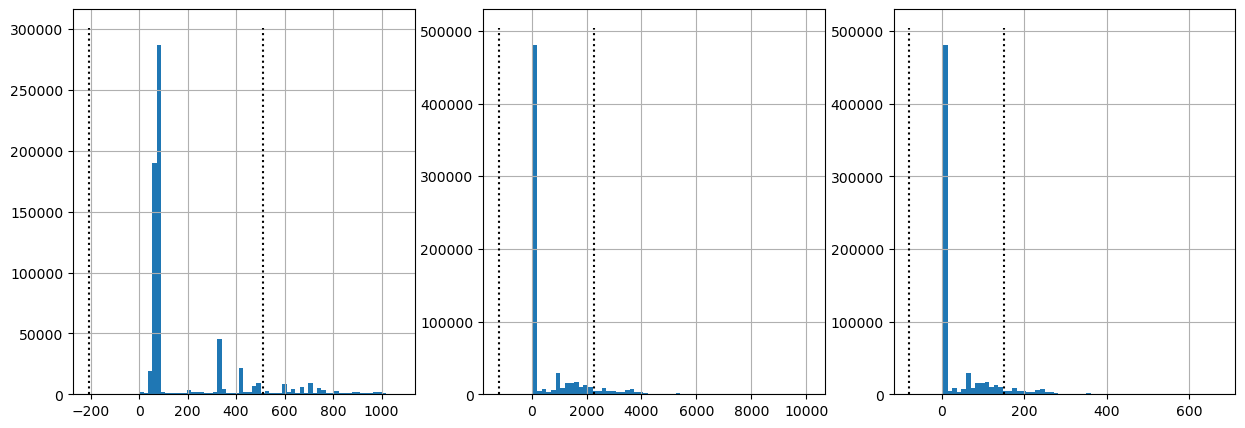

In [266]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

for i, col in enumerate(['len_NT_to_TT','len_sum_of_parts', 'len_mean_of_parts']):
    hist = df_combined_test[col].hist(bins=60, ax=axes[i])
    
    Q1, Q3 = df_combined_test[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 1.7*IQR
    high_thresh = Q3 + 1.7*IQR
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='k', linestyles='dotted')

In [267]:
remove_outliers_IQR(df_combined_test, 'len_NT_to_TT')
remove_outliers_IQR(df_wo_outliers, 'len_sum_of_parts')

In [268]:
len(df_wo_outliers.index) / len(df_combined_test.index)

0.8183874435605246

In [269]:
cols_curv = list(df_wo_outliers.filter(like='curv').columns)
cols_curv

['curv_NT',
 'curv_DH1',
 'curv_DH2',
 'curv_DNP',
 'curv_DTP1',
 'curv_DTP2',
 'curv_DTP3',
 'curv_DTP4',
 'curv_DTP5',
 'curv_DTP6',
 'curv_DTP7',
 'curv_DTP8',
 'curv_DTP9',
 'curv_DTP10',
 'curv_TT']

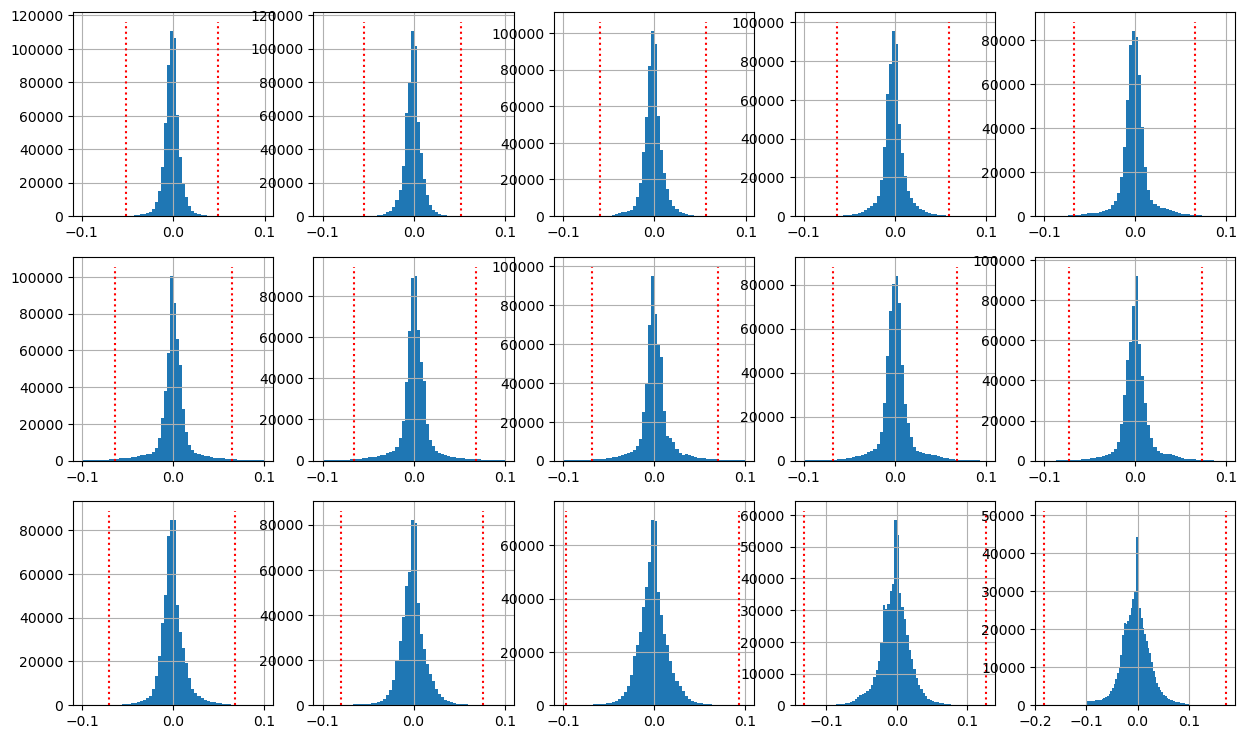

In [270]:
fig, axes = plt.subplots(3,5,figsize=(15, 9))
axes = axes.ravel()
for i, col in enumerate(cols_curv):
    hist = df_wo_outliers.loc[(df_wo_outliers[col]<0.1) & (df_wo_outliers[col]>-0.1), col].hist(ax=axes[i], bins=60)
    # .loc[(df_wo_outliers[col]<0.1) & (df_wo_outliers[col]>-0.1), col]
    
    # print(stats.shapiro(df_combined_test.loc[(df_combined_test[col]<0.1) & (df_combined_test[col]>-0.1), col]))
    Q1, Q3 = df_wo_outliers[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 5*IQR
    high_thresh = Q3 + 5*IQR
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

In [271]:
df_wo_outliers

,len_NT_to_TT,len_sum_of_parts,len_mean_of_parts,curv_NT,curv_DH1,curv_DH2,curv_DNP,curv_DTP1,curv_DTP2,curv_DTP3,...,speed_VTP8,speed_VTP7,speed_VTP6,speed_VTP5,speed_VTP4,speed_VTP3,speed_VTP2,speed_VTP1,speed_VNP,MOUTH
0,58.556391,121.986974,8.132465,0.002747,0.008599,0.005984,0.004895,0.002223,0.006569,-0.008459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,54.780271,112.061200,7.470747,-0.006481,-0.003456,-0.006633,-0.015413,-0.023643,-0.007650,-0.006967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,60.175949,128.351231,8.556749,-0.003500,-0.003287,-0.003524,-0.006942,-0.010419,-0.042153,-0.027122,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,53.550173,111.557206,7.437147,-0.010190,-0.009334,-0.010965,-0.018913,-0.025498,-0.025259,-0.017712,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,53.429537,111.996814,7.466454,-0.011177,-0.007488,-0.009124,-0.016018,-0.022658,-0.022512,-0.024905,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993,701.450751,1507.190799,100.479387,-0.008315,0.005553,0.016751,0.023567,0.034567,0.036717,0.032828,...,4.551215,8.675571,5.655545,7.598886,2.999867,4.962952,2.114061,0.877919,2.017286,1.0
8994,702.428202,1497.780833,99.852056,-0.003062,-0.008279,-0.008498,-0.007811,-0.002212,0.004679,0.014853,...,12.317761,11.007467,7.490452,7.820805,3.047544,2.873669,0.578385,2.202875,2.483416,1.0
8995,62.609821,134.196988,8.946466,0.008705,0.012746,0.009288,0.008015,0.000881,-0.011305,-0.019011,...,4.551215,8.675571,6.296348,5.394252,5.890033,1.818114,7.441955,8.492354,3.319379,1.0
8997,702.952496,1506.238710,100.415914,0.002930,0.005722,0.016137,0.023298,0.030564,0.031711,0.031960,...,0.582115,0.155261,0.405242,0.284851,0.254159,4.040793,4.050773,4.025378,3.503703,1.0


In [272]:
for i, col in enumerate(cols_curv):
    remove_outliers_IQR(df_wo_outliers, col)

In [273]:
cols_speed = list(df_combined_test.filter(like='speed').columns)
len(cols_speed)

26

In [274]:
sample_curves = np.random.choice(df_combined_test.loc[df_combined_test[cols_speed].isna().sum(axis=1) == 0, cols_speed].values.ravel(), 1000, replace=False)
stats.lognorm.fit(sample_curves)

(1.3145451952149387, 0.013864590995667718, 0.7749382743214477)

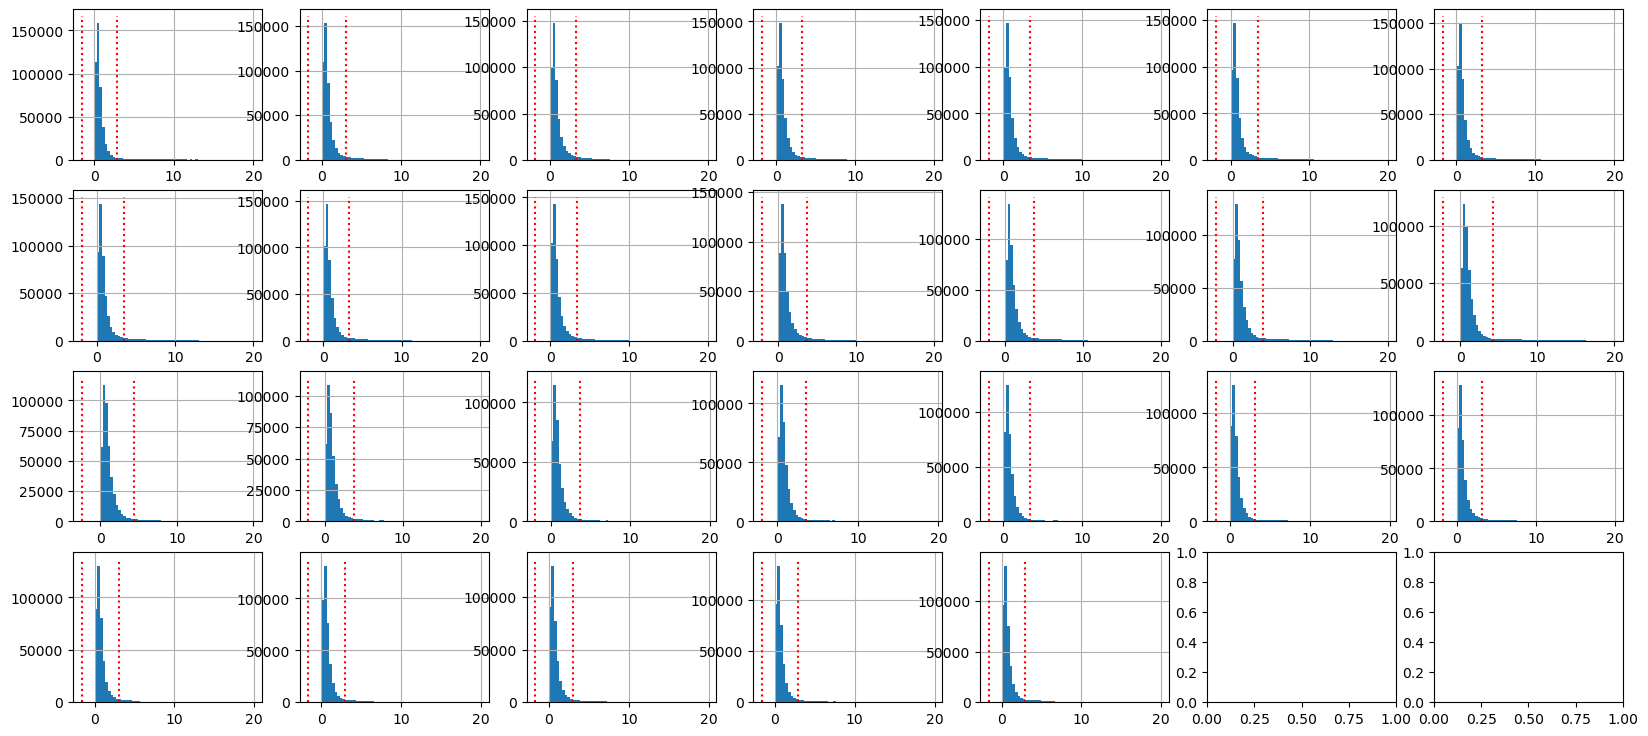

In [275]:
fig, axes = plt.subplots(4,7,figsize=(20, 9))
axes = axes.ravel()
for i, col in enumerate(cols_speed):
    hist = df_wo_outliers.loc[(df_wo_outliers[col] >= 0) & (df_wo_outliers[col] < 20), col].hist(ax=axes[i], bins=60)
    
    # print(stats.kstest(df_combined_test.loc[(df_combined_test[col]<20), col], "lognorm", stats.lognorm.fit(sample_curves)))
    Q1, Q3 = df_wo_outliers[col].quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 3*IQR
    high_thresh = Q3 + 3*IQR
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3

0.009351075446173623 43.20923089052267
0.00936894930459332 52.89085733958618
0.008874931827547623 60.2610657627067
0.009105853548334188 61.263309276101985


/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.007793679424594242 82.90846958829057
0.007918760037710087 73.95224281613405
0.009133285200374415 54.751472196929626
0.007268765480927929 75.8472632075989


/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.007505439387394016 70.20172374851887
0.008149105703597876 69.96592422290924
0.008664457543058024 78.74966498449976
0.01098271942826053 65.99871443548336


/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/

0.009360684620253046 85.82609853009937
0.013045691153594038 61.018326720718804
0.009941939636552684 82.14183535815754
0.01618825389872892 40.3471179651729


/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.014461595228403732 39.15076025437979
0.013560016175118235 38.958214317039186
0.013559787340599882 34.95222209564761
0.011999942705771543 36.78554133976175


/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.011417914017406038 40.50636794754298
0.013125290069114438 32.15888793549131
0.011848318982815034 32.09255121695153
0.01206590934884911 33.525142157022735


/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/athira/anaconda3/envs/amphi/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0.01130747367929724 34.25815489112795
0.011840658561982442 32.245862437703074


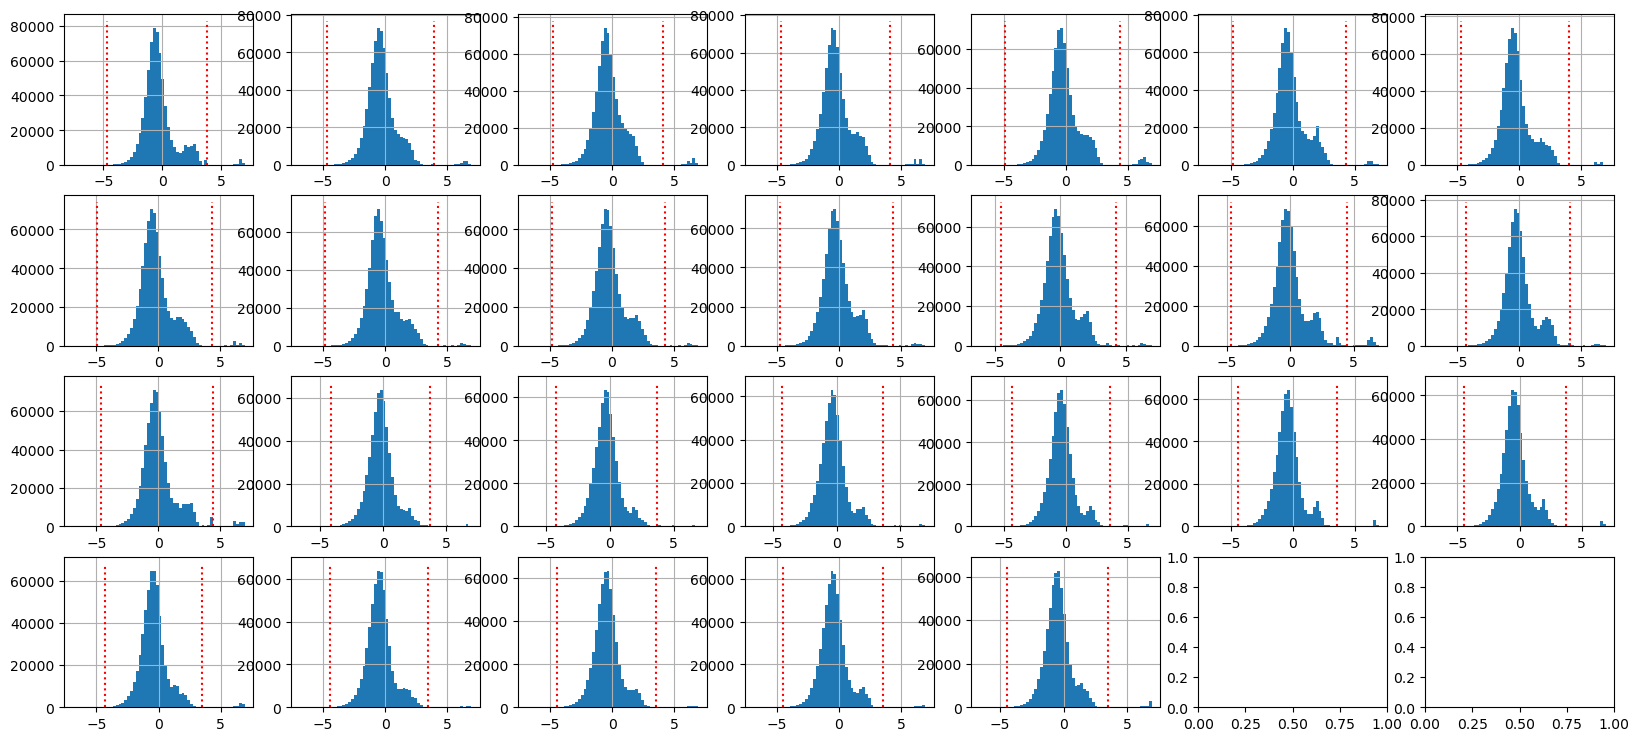

In [293]:
fig, axes = plt.subplots(4,7,figsize=(20, 9))
dict_thresh_speeds = {}
axes = axes.ravel()
df_combined_test.replace([np.inf, -np.inf], np.nan, inplace=True)

for i, col in enumerate(cols_speed):
    sel_data = df_combined_test[col]
    sel_data = sel_data[(sel_data.notna())]
    log_vals = np.log(sel_data)
    hist = log_vals[(log_vals!=np.inf)&(log_vals!=-1*np.inf)&(log_vals!=np.nan)].hist(ax =axes[i], bins=60)
    
    Q1, Q3 = log_vals.quantile([.25, .75])
    IQR = Q3 - Q1
    low_thresh = Q1 - 3*IQR
    high_thresh = Q3 + 3*IQR

    dict_thresh_speeds[col] = [low_thresh, high_thresh]

    print(np.exp(low_thresh), np.exp(high_thresh))
    
    ymin, ymax = hist.get_ylim()
    axes[i].vlines(x=[low_thresh, high_thresh], ymax= ymax, ymin=ymin, colors='r', linestyles='dotted')

<AxesSubplot: >

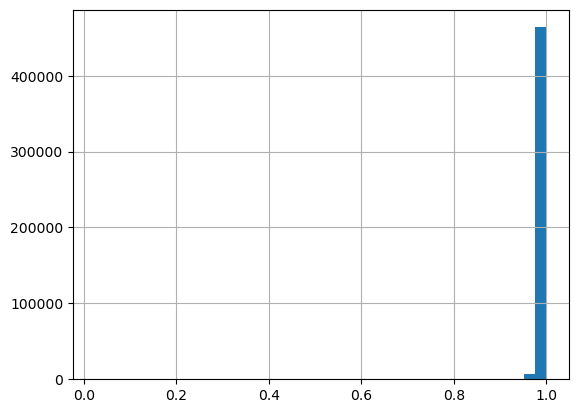

In [277]:
df_wo_outliers['quirkiness'].hist(bins=40)

In [278]:
len(df_wo_outliers.index)

471949

In [279]:
len(df_combined_test.index)

697650

In [280]:
(len(df_wo_outliers.index) / len(df_combined_test.index)) * 100

67.64839102701929